# Embed financial loan data and then use embeddings to predict risk

In [8]:
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os


In [31]:
# get the API key from the json file
openai.api_key = os.environ.get('OPENAI_API_KEY')

In [12]:
import pandas as pd
import openai
import json

# read in the credit_risk_dataset.json file into a pandas dataframe
whole_df = pd.read_csv('credit_risk_dataset.csv')
# cut it down to 200 rows for testing
df = whole_df[0:200]
# find features with missing values or NaN
print(df.isnull().sum())

# clean the data replace NaN with -99.0
df = df.fillna(-99.0)
#re-order the columns so loan_status is last
cols = list(df.columns.values)
cols.pop(cols.index('loan_status'))
df = df[cols+['loan_status']]
# replace loan_status values 0 with paid and 1 with default
#df['loan_status'] = df['loan_status'].replace(0, 'low risk')
#df['loan_status'] = df['loan_status'].replace(1, 'high risk')



person_age                     0
person_income                  0
person_home_ownership          0
person_emp_length              1
loan_intent                    0
loan_grade                     0
loan_amnt                      0
loan_int_rate                 22
loan_status                    0
loan_percent_income            0
cb_person_default_on_file      0
cb_person_cred_hist_length     0
dtype: int64


In [23]:

# create jsonl file with {"prompt": "data ->", " completion": "loan_status\n\n"} where data is all colums except loan_status
# and loan_status is the value of the loan_status column
# this will be used as the prompt for the GPT-3 model
tdata = []
tstatus = []
for index, row in df.iterrows():
    loan_status = row['loan_status']
    # drop the loan_status column
    row = row.drop('loan_status')
    # convert row to dictionary
    row = row.to_dict()
    # convert dictionary to string
    data = json.dumps(row)
    # remove curly braces
    data = data.replace('{', '')
    data = data.replace('}', '')
    data = data.replace('"', '')
    tdata.append(data)
    tstatus.append(loan_status)

# print length of tdata and tstatus
print(len(tdata))
print(len(tstatus))
print(tdata[0])

200
200
data: person_age: 22, person_income: 59000, person_home_ownership: RENT, person_emp_length: 123.0, loan_intent: PERSONAL, loan_grade: D, loan_amnt: 35000, loan_int_rate: 16.02, loan_percent_income: 0.59, cb_person_default_on_file: Y, cb_person_cred_hist_length: 3, embeddings: [-0.020213359966874123, -0.003564889542758465, 0.013527092523872852, -0.046850912272930145, -0.02093910612165928, 0.002635867800563574, -0.01850651390850544, 0.016880305483937263, -0.0373087003827095, -0.03367997333407402, -0.0008702227496542037, 0.02429903857409954, -0.005490131210535765, -0.004905502777546644, -0.0022259559482336044, 0.02647627517580986, 0.008655188605189323, -0.03921714425086975, 0.024755990132689476, -0.03007812425494194, -0.028868548572063446, 0.011161698959767818, -0.03306174650788307, -0.0004624108551070094, -0.0096497293561697, -0.013338935561478138, 0.007916003465652466, -0.017175979912281036, 0.0001877362810773775, -0.020737510174512863, 0.018063003197312355, -0.01158505119383335

In [16]:
import pandas as pd


# create a pandas from tdata and tstatus as columns
df = pd.DataFrame({'data': tdata, 'loan_status': tstatus})
# set mini-df to 1000 rows
df.size


400

In [17]:

# loop over the dataframe and calcula   te the embedding for each row
embeddings = []
for index, row in df.iterrows():
    model="text-embedding-ada-002"
    vec = openai.Embedding.create(input = [row['data']], model=model)['data'][0]['embedding']
    embeddings.append(vec)
    #embeddings = np.append(embeddings, [vec], axis=0)
print (len(embeddings[0]))
# write embeddings to a df 
df["embeddings"] = embeddings

df.to_csv('risk_Embed.csv')

1536


In [37]:
from sklearn.manifold import TSNE
import matplotlib
from ast import literal_eval
import numpy as np
from ast import literal_eval
embed = pd.read_csv('risk_Embed.csv')
tsne = TSNE(n_components=2, perplexity=10, random_state=3)
# convert Pandas embedding array to a numpy array of arrays
# The matrix is calculated from the ebmeddings 
matrix = np.array(embed.embeddings.apply(literal_eval).to_list())  # this is the line that takes a while
print(matrix.shape)
X_2d = tsne.fit_transform(matrix)
print(X_2d.shape)


(200, 1536)
(200, 2)


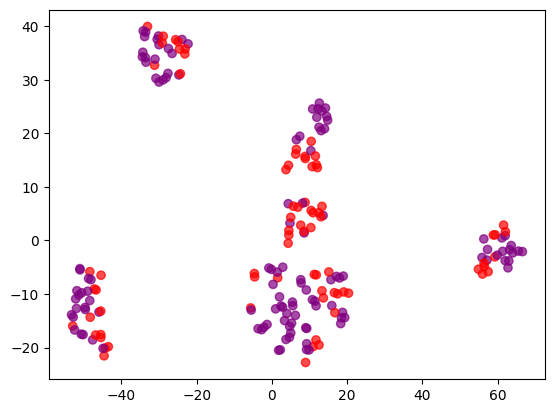

In [38]:
colors = ["red", "darkorange",  "blue", "darkgreen","purple"]
# get back original dataframe with columns and loan_status
ddf=whole_df[0:200]
x = [x for x,y in X_2d]
y = [y for x,y in X_2d]
color_indices = ddf['loan_status'].tolist() 
colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.7)
plt.show()

### Dataframe of embeddings causes problems. We need to be careful because "data.embeddings" is a Pandas Series and we need a Numpy matrix ie array of arrays or as above a list of lists will also be OK

In [33]:
# creat matrix out of numpy array of arrays
from sklearn.manifold import TSNE
import matplotlib
from ast import literal_eval
import numpy as np
from ast import literal_eval
tsne = TSNE(n_components=2, perplexity=50, random_state=3)

# transform embeddings from list of lists to numpy array of arrays
for i in range(len(embeddings)):
    embeddings[i] = np.array(embeddings[i])
matrix = np.array(embeddings)
print (type(matrix))
print(matrix[0].shape)
# change the shape of the matrix to be 2D (required for TSNE)
matrix = matrix.reshape(-1, 1536)
print(matrix.shape)
X_2d = tsne.fit_transform(matrix)




<class 'numpy.ndarray'>
(1536,)
(200, 1536)


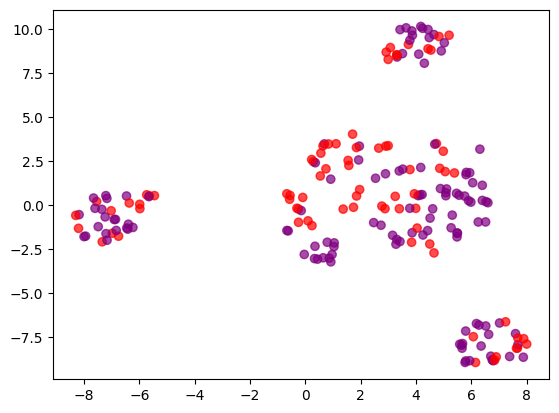

In [34]:
colors = ["red", "darkorange",  "blue", "darkgreen","purple"]
# get back original dataframe with columns and loan_status
ddf=whole_df[0:200]
x = [x for x,y in X_2d]
y = [y for x,y in X_2d]
color_indices = ddf['loan_status'].tolist() 
colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.7)
plt.show()


AttributeError: 'list' object has no attribute 'Area'

In [179]:
# split the data into training and test sets for classification of Score from the embeddings
# Score = sentiment,  Area = product category
from sklearn.model_selection import train_test_split

matrix = np.array(complaints.embeddings.apply(literal_eval).to_list())
X_train, X_test, y_train, y_test = train_test_split(
    complaints.embeddings.apply(literal_eval).to_list(),
    complaints.Score.values,  # Score = +1 or -1 AND Area = 0,1,2,3 
    test_size = 0.2,
    random_state=42
)
# print lenght of training set
print(len(X_train))

80


In [180]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=10) # n_estimators is the number of trees
rfr.fit(X_train, y_train)
preds = rfr.predict(X_test)
print(preds)
# these should be +1 or -1 for the sentiment and Areas 0,1,2,3 for the product categories

[ 0.8 -0.8  1.   1.  -0.8  1.  -0.8 -1.   1.  -1.   0.   0.6 -1.  -1.
  0.4  1.   1.  -1.   1.   1. ]


In [181]:
# compare the predictions to the actual scores
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, preds))
print(rmse)

0.28982753492378877
